<a href="https://colab.research.google.com/github/UdaraChamidu/LangGraph/blob/main/AI_Agent_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple AI Agent with Web search Tool, Weather Tool and Calculation Tool

In [61]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q
!pip install langgraph -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.24 requires langchain<1.0.0,>=0.3.25, but you have langchain 0.3.24 which is incompatible.


In [62]:
# google search tool and weather tool

!pip install langchain_community -q
!pip install duckduckgo-search -qU
!pip install pyowm -qU

In [63]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [64]:
# for new tools. (calculation tools are created by me but others...)

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools

In [65]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [66]:
# initialize the llm

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    temperature=0
)

In [67]:
os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHER_API_KEY')

In [68]:
# initialize tools

search_tool = DuckDuckGoSearchRun()

weather = OpenWeatherMapAPIWrapper()
weather_tool = load_tools(["openweathermap-api"], llm)[0]



In [69]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]  # new msgs also adding...

In [70]:
# tools

@tool
def addition(a: int, b: int):
  """This is the addition function that adds 2 numbers"""  # discription
  # according to discription, model decides which tool to use.
  return a+b

@tool
def subtraction(a: int, b: int):
  """This is the subtraction function that subtracts 2 numbers"""
  return a-b

@tool
def multiplication(a: int, b: int):
  """This is the multiplication function that multiplies 2 numbers"""
  return a*b

@tool
def division(a: int, b: int):
  """This is the division function that divides 2 numbers"""
  return a/b


In [71]:
tools = [addition, subtraction, multiplication, division, search_tool, weather_tool]

In [72]:
# llm enables to access tools

llm_with_tools = llm.bind_tools(tools)

In [73]:
def llm_call(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content=
    "You are an intelligent AI assistant, please answer my query."
  )
  response = llm_with_tools.invoke([system_prompt] + state["messages"])
  # now, not only llm. now there are tools also

  return {"messages":[response]}


In [74]:
# which tool is use ?

def decision_node(state: AgentState):
  message = state["messages"]
  last_message = message[-1]  # again use a tool or not
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [75]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)

tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.add_edge( START, "agent" )
workflow.add_conditional_edges(
  "agent",
  decision_node,
  {
    "continue": "tools",  # if continue, use tools ...
    "end": END,           # else end.
  },
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

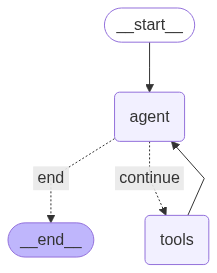

In [76]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [77]:
# check step by steps of tool using

def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)
    else:
      message.pretty_print()

In [95]:
inputs = {"messages": [("user", "what is codeprolk?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is codeprolk?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_g5LaXPCMT30srg4Ut5JiWQvH)
 Call ID: call_g5LaXPCMT30srg4Ut5JiWQvH
  Args:
    query: codeprolk
================================= Tool Message =================================
Name: duckduckgo_search

Who is an AI / ML Engineer, An AI engineer is a professional who designs, builds, and implements artificial intelligence (AI) models and applications. ඇයි Python ඉගෙනගන්න ඕනෙ?🔥Support us: https://www.patreon.com/codeprolk Want to learn more? 🚀 Machine Learning Tutorial - https://www ... CodePRO LK. Reels󰞋Jun 20, 2024󰞋󱟠 󰟝 At Microsoft Build 2025, the tech giant outlined a bold new vision for the future of computing: one where AI agents—digital entities capable of reasoning, remembering, and independently executing tasks—act as true partners for both individuals and organiza